## Budget in MITgcm. Part V: Depth-averaged Hydrostatic energy budget
**24 March 2020 by MiniUFO and Wendy**

---
[TOC]

---
### 1. Introduction
As Part V of a series of notebook here, we will carry out depth-averaged kinetic energy budget using the model of [MITgcm](http://mitgcm.org/), and its related [python](https://www.python.org/) analysis package like [xmitgcm](https://github.com/xgcm/xmitgcm) and [xgcm](https://github.com/xgcm/xgcm).  This is usually done in tide-related simulations.  Now this part will be advanced from Part IV.  So please ensure that you have already closed the non-averaged hydrostatic energy equation.

---

### 2. Theoretical guide
###### 2.1 General equation for the momentum
The depth-averaged kinetic energy equation is based on the raw energy equation as (see [Part IV](http://210.77.91.122:9999/notebooks/GeoApps/notebooks/Budget%20in%20MITgcm%20Part%20IV%20Eng.ipynb)).
>$$\frac{\partial E_k}{\partial t}=-\nabla\cdot(\mathbf u E_k)+PG+DIFF+DISS+\mathbf u_H\cdot \mathbf F_H \tag{1}$$

where the hydrostatic kinetic energy is defined as $E_k=(\mathbf u_H \cdot \mathbf u_H)/2$ (no $w^2/2$ contribution).  Taking depth-average of velocity we have the mean (barotropic) velocity as:
>$$\mathbf U=\int_{-H}^{\eta}\mathbf u dz \tag{2}$$

>$$\mathbf u'=\mathbf u - \mathbf U \tag{3}$$



###### 2.2 Pressure gradient terms
In MITgcm, the pressure gradient term is splitted into [three parts](https://mitgcm.readthedocs.io/en/latest/overview/hydrostatic.html): the surface, hydrostatic and nonhydrostatic terms:
>$$PG=-\mathbf u_H\nabla_H (g\eta)-\frac{1}{\rho_0}\nabla\cdot (\mathbf u p_{hyd})-\frac{1}{\rho_0}\nabla\cdot (\mathbf up_{nh}) \tag{4}$$

Notice that if your forcing includes Atmospheric pressure loading (`=atmP_load`), this contribution (`=-gradient`) needs to be added:

**`-1/rhoConst * (atmP_load(i) - atmP_load(i-1)) / dxC`**

and the same thing applies to seaice-loading:

**`-g/rhoConst * (sIceLoad(i) - sIceLoad(i-1)) / dxC`**

The fixed density to use is "`rhoConst`" and not "`rhoConstFresh`"

Note that the pressure gradient tendency due to surface elevation should be calculated using `PHI_SURF` rather than `ETAN`, because the implicit free surface uses `ETAN(n+1)` rather than `ETAN(n)` ([see Point c here](http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-December/008702.html) and [Point 2a here](http://mailman.mitgcm.org/pipermail/mitgcm-devel/2019-March/007065.html))..

###### 2.3 Advection terms
Notice that the kinetic energy $E_k$ is defined at the [tracer point](https://xgcm.readthedocs.io/en/latest/example_mitgcm.html#Kinetic-Energy), which need a interpolation of momentum components from velocity points to the tracer point.  Then one need to interpolate the $E_k$ to the velocity points for divergent calculation.

###### 2.4 Diffusion and dissipation terms
Note that the diffusion and dissipation terms are in a form slightly different from those as shown in [Osborn (1980, see his Eq. (5-6))](https://journals.ametsoc.org/doi/pdf/10.1175/1520-0485%281980%29010%3C0083%3AEOTLRO%3E2.0.CO%3B2).  Here we use the form in ([Kang's dissertation](https://stacks.stanford.edu/file/druid:sv691gk5449/kdj_thesis-augmented.pdf)).  It is not clear which form is better for [Arakawa C-grid](https://mitgcm.readthedocs.io/en/latest/algorithm/c-grid.html) discretizing.

###### 2.5 External forcings
External forcing includes the surface wind stress.

###### 2.6 Adams Bashforth integrator
There is a extra tendency due to the Adams-Bashforth integrator.  One need to take into account this to close the budget.

---

### 3. Practice using xgcm/xmitgcm
According to the above, the kinetic energy tendency (KEtdc) budget equation is:
**total_tdc = advct_tdc + convs_tdc + press_tdc + diffu_tdc + dissi_tdc**

The MITgcm output diagnostics required for the heat budget are:

| Names in Equation |  Outpus required by MITgcm  | Description |
| ------------: | --------------------------- | ------------------- |
|  total_tdc | `UVEL`, `VVEL` | total tendency of kinetic energy |
|  advct_tdc | `UVEL`, `VVEL`, `WVEL` | tendency due to 3D advection |
|  viscE_tdc | `UVEL`, `VVEL` | tendency due to conversion to potential energy |
|  viscI_tdc | `UVEL`, `VVEL`, `VISrI_Um`, `VISrI_Vm` | tendency due to conversion to potential energy |
|  prsGF_tdc | `UVEL`, `VVEL`, `Um_dPHdx`, `Um_dPHdy`, `PHI_SURF` | tendency due to pressure gradient work |
|  exfrc_tdc | `UVEL`, `VVEL`, `Um_Ext`, `Vm_Ext` | tendency due to energy diffusion |
|  AdamB_tdc | `UVEL`, `VVEL`, `WVEL` | tendency due to viscous dissipation |

One can find these names in available_diagnosis.log generated in the run directory and set them in data.diagnostics for output.  Then we start the budget analysis using [python](https://www.python.org/) and related packages.

First, we define a [EnergyBudget](https://github.com/miniufo/GeoApps/blob/master/Budget.py) class in Python code.  Using the [EnergyBudget](https://github.com/miniufo/GeoApps/blob/master/Budget.py) class, the kinetic energy budget can be easily diagnosed like:


In [3]:
import matplotlib.pyplot as plt
import xmitgcm
import xarray as xr
import sys
sys.path.append('../../')
from GeoApps.Budget import EnergyBudget
from GeoApps.GridUtils import add_MITgcm_missing_metrics


indir = 'I:/channel/output_budget/'

deltaTmom = 300

dset = xmitgcm.open_mdsdataset(indir, grid_dir='I:/channel/',
                    delta_t=deltaTmom, read_grid=True,
                    prefix=['Stat3D', 'Surf2D', 'DiagU', 'DiagV'])

dset, grid = add_MITgcm_missing_metrics(dset, periodic='X')


budget = EnergyBudget(dset, grid, hydrostatic=True)

# obtains variables
UVEL     = dset['UVEL'    ]
VVEL     = dset['VVEL'    ]
WVEL     = dset['WVEL'    ]
PHI_SURF = dset['PHI_SURF']
Um_dPHdx = dset['Um_dPHdx']
Vm_dPHdy = dset['Vm_dPHdy']
Um_Ext   = dset['Um_Ext'  ]
Vm_Ext   = dset['Vm_Ext'  ]
PHIHYD   = dset['PHIHYD'  ]
AB_gU    = dset['AB_gU'   ]
AB_gV    = dset['AB_gV'   ]
VISrI_Um = dset['VISrI_Um']
VISrI_Vm = dset['VISrI_Vm']

KE       = budget.cal_kinetic_energy(UVEL, VVEL)

budget.cal_true_tendency(KE, 10800)

budget.cal_advection_tendency(UVEL, VVEL, WVEL, KE)
budget.cal_diffusion_tendency(KE, 12, 0)
budget.cal_surf_tendency(UVEL, VVEL, PHI_SURF)
budget.cal_pressure_tendency(UVEL, VVEL, Um_dPHdx, Vm_dPHdy)
budget.cal_dissipation_tendency(UVEL, VVEL, WVEL, 12, 0)
budget.cal_external_force_tendency(UVEL, VVEL, Um_Ext, Vm_Ext)
budget.cal_Adams_Bashforth_tendency(UVEL, VVEL, AB_gU, AB_gV)
budget.cal_viscousE_tendency(UVEL, VVEL, None, 12, 0)
budget.cal_viscousI_tendency(UVEL, VVEL, VISrI_Um, VISrI_Vm)

re = budget.terms

total =  re.total_tdc
sumup = (re.advct_tdc + # advective tendency = adv_x_tdc + adv_y_tdc + adv_r_tdc
         re.viscE_tdc + # explicit viscous dissipation tendency = visUE_tdc + visVE_tdc
         re.viscI_tdc + # implicit viscous dissipation tendency = visUI_tdc + visVI_tdc
         re.prsSF_tdc + # surface pressure gradient tendency = prsSx_tdc + prsSy_tdc
         re.prsGF_tdc + # hydrostatic pressure gradient tendency = prsGx_tdc + prsGy_tdc
         re.exfrc_tdc +
         re.AdamB_tdc)

C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list stru

We then get a Dataset named ```re```, and it contains all the related energy budget terms:

In [4]:
print(re)

<xarray.Dataset>
Dimensions:    (XC: 200, YC: 400, Z: 30, time: 3)
Coordinates:
  * time       (time) int64 1866250800 1866261600 1866272400
  * Z          (Z) >f4 -5.0 -15.0 -27.5 -45.0 ... -2580.0 -2830.0 -3080.0
  * YC         (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XC         (XC) >f4 2500.0 7500.0 12500.0 ... 987500.0 992500.0 997500.0
    drF        (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    PHrefC     (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    RhoRef     (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    rA         (YC, XC) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    Depth      (YC, XC) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    hFacC      (Z, YC, XC) >f4 dask.array<chunksize=(30, 400, 200), meta=np.ndarray>
    maskC      (Z, YC, XC) bool dask.array<chunksize=(30, 400, 200), meta=np.ndarray>
    maskInC    (YC, XC) bool dask.array<chunksize=(400, 200), meta=np.ndarray>
    dxF        (YC

It is important to note that some processes use a different schemes from the dot product of velocity and the momentum equation, which lead to some residual errors in the final budget.  These processes are:
1. **Total tendency**
>$$\frac{\partial E_k}{\partial t}=u\frac{\partial u}{\partial t}+v\frac{\partial v}{\partial t} \tag{5}$$

2. **Advective tendency**
>$$\nabla\cdot (\mathbf u E_k)=u(\mathbf u\cdot \nabla u)+v(\mathbf u\cdot \nabla v) \tag{6}$$

3. **Explicit viscous dissipation tendency**
>$$\nabla_H\cdot (\mu \nabla_H E_k)-[(\nabla u)^2+(\nabla v)^2]=u(\nabla_H \cdot \mu \nabla_H u)+v(\nabla_H \cdot \mu \nabla_H v) \tag{7}$$

The lhs is current implementation in [EnergyBudget](https://github.com/miniufo/GeoApps/blob/master/Budget.py) class while rhs is in momentum equation.  In order to compare the terms in Eq. (7), we have included `diffu_tdc`=$\nabla_H\cdot (\mu \nabla_H E_k)$, `dissi_tdc`=$-(\nabla u)^2-(\nabla v)^2$, `visUE_tdc`=$u(\nabla_H \cdot \mu \nabla_H u)$, and `visVE_tdc`=$v(\nabla_H \cdot \mu \nabla_H v)$.  Now we verify Eq. (7) as:

C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


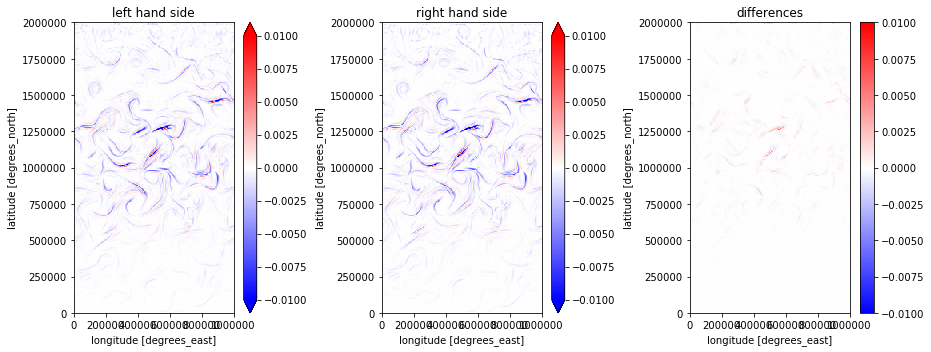

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

lhs = (re.diffu_tdc + re.dissi_tdc)[0,0]
rhs = (re.visUE_tdc + re.visVE_tdc)[0,0]
dff = lhs - rhs

lhs.plot(ax=axes[0], cmap='bwr', vmax=0.01, vmin=-0.01)
axes[0].set_title('left hand side')
rhs.plot(ax=axes[1], cmap='bwr', vmax=0.01, vmin=-0.01)
axes[1].set_title('right hand side')
dff.plot(ax=axes[2], cmap='bwr', vmax=0.01, vmin=-0.01)
axes[2].set_title('differences')

plt.tight_layout()

As the calculation is completed, we can demonstrate the contributions from all kinds of processes and verify that the sum of all terms is the total tendency for kinetic energy.  All the terms are in unit of m^2 s^-2 per day.

C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


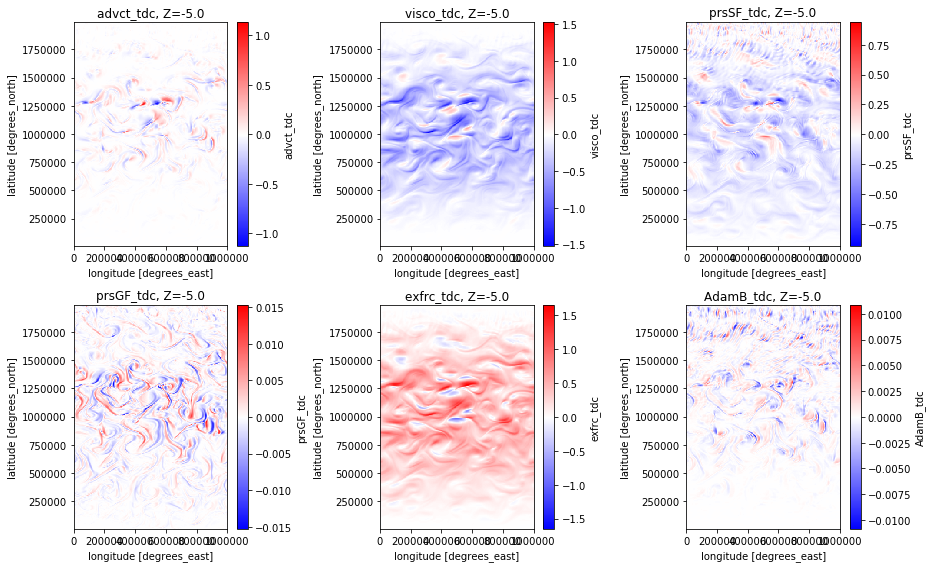

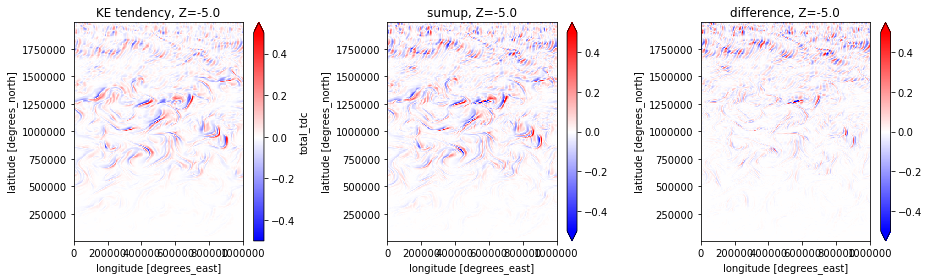

In [18]:
zidx = 0

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))

axes = axes.ravel()

terms = [re.advct_tdc,
         (re.viscE_tdc+re.viscI_tdc).rename('visco_tdc'),
         re.prsSF_tdc,
         re.prsGF_tdc,
         re.exfrc_tdc,
         re.AdamB_tdc]

sumup = (re.advct_tdc +
         re.viscE_tdc + re.viscI_tdc +
         re.prsSF_tdc +
         re.prsGF_tdc +
         re.exfrc_tdc +
         re.AdamB_tdc)

for i, var in enumerate(terms):
    var[2, zidx, 1:-2, :].plot(ax=axes[i], cmap='bwr', add_colorbar=True)
    axes[i].set_title("{0}, Z={1}".format(var.name, dset.Z[zidx].values))

plt.tight_layout()


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))

re.total_tdc[1, zidx, 1:-2, :].plot(ax=axes[0], cmap='bwr',
                                    add_colorbar=True, vmin=-0.5, vmax=0.5)
axes[0].set_title("{0}, Z={1}".format('KE tendency', dset.Z[zidx].values))
sumup[1, zidx, 1:-2, :].plot(ax=axes[1], cmap='bwr',
                             add_colorbar=True, vmin=-0.5, vmax=0.5)
axes[1].set_title("{0}, Z={1}".format('sumup', dset.Z[zidx].values))
(re.total_tdc-sumup)[1, zidx, 1:-2, :].plot(ax=axes[2], cmap='bwr',
                             add_colorbar=True, vmin=-0.5, vmax=0.5)
axes[2].set_title("{0}, Z={1}".format('difference', dset.Z[zidx].values))


plt.tight_layout()

From the above figure, we can see that heat tendency budgets are almost closed (overlap of **True tendency** and **sum-up tendency**).  Some numerical shemes cause the non-exact overlap of the two, but the results are acceptable.

#### References
1. <http://hornby.seos.uvic.ca/~jklymak/MITgcm/EnergyDiagnostic.pdf>